# When Does Machine Learning Fail?  
## A Broad Stress Test of Common Models (LogReg vs Random Forest vs MLP)

**Goal:** Instead of only reporting baseline accuracy, we systematically stress-test models under realistic failure modes:
1. Feature noise injection  
2. Label corruption  
3. Distribution shift  
4. Feature removal (sensor/feature failure)  
5. Confidence collapse / (optional) calibration



In [ ]:
# --- 0) Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 200)


## 1) Load Dataset

Default: **Adult Income** (OpenML).  
If OpenML is unavailable in your environment, put a local CSV path in `LOCAL_CSV_PATH`.

**Target:** `income` (">50K" vs "<=50K")  


In [ ]:
LOCAL_CSV_PATH = None
def load_adult_income(local_csv_path: Optional[str] = None) -> pd.DataFrame:

    if local_csv_path is not None:
        df = pd.read_csv(local_csv_path)
        return df

    # OpenML fetch (requires internet access in your Python environment)
    from sklearn.datasets import fetch_openml
    adult = fetch_openml("adult", version=2, as_frame=True)
    df = adult.frame.copy()

    # Standardize target name for consistency
    # OpenML target is often called 'class'
    if "class" in df.columns and "income" not in df.columns:
        df = df.rename(columns={"class": "income"})

    return df

df = load_adult_income(LOCAL_CSV_PATH)
df.head(), df.shape


(   age  workclass  fnlwgt     education  education-num      marital-status  \
 0   25    Private  226802          11th              7       Never-married   
 1   38    Private   89814       HS-grad              9  Married-civ-spouse   
 2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
 3   44    Private  160323  Some-college             10  Married-civ-spouse   
 4   18        NaN  103497  Some-college             10       Never-married   
 
           occupation relationship   race     sex  capital-gain  capital-loss  \
 0  Machine-op-inspct    Own-child  Black    Male             0             0   
 1    Farming-fishing      Husband  White    Male             0             0   
 2    Protective-serv      Husband  White    Male             0             0   
 3  Machine-op-inspct      Husband  Black    Male          7688             0   
 4                NaN    Own-child  White  Female             0             0   
 
    hours-per-week native-country in

In [ ]:
# Quick sanity checks
print(df.columns.tolist())
print(df["income"].value_counts(dropna=False))


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
income
<=50K    37155
>50K     11687
Name: count, dtype: int64


## 2) Train/Test Split + Preprocessing

We use a standard pipeline:
- Separate numeric vs categorical columns
- Impute missing values
- One-hot encode categoricals
- Scale numeric features (important for Logistic Regression + MLP)

Then we define 3 models:
- Logistic Regression
- Random Forest
- MLP (2-layer)


In [ ]:
# --- 2) Split data ---
TARGET_COL = "income"

# Convert target to 0/1
y_raw = df[TARGET_COL].astype(str)
y = (y_raw.str.contains(">50K")).astype(int)

X = df.drop(columns=[TARGET_COL])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

# Identify column types
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")


Numeric cols: 6 | Categorical cols: 8


In [ ]:
# --- 2) Preprocess pipelines ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

# Models (keep them stable / not over-tuned)
models = {
    "LogReg": LogisticRegression(max_iter=2000, n_jobs=None),
    "RandForest": RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=40,
        random_state=RANDOM_SEED,
    ),
}

def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model),
    ])

pipelines = {name: make_pipeline(m) for name, m in models.items()}
pipelines


{'LogReg': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['age', 'fnlwgt',
                                                    'education-num',
                                                    'capital-gain',
                                                    'capital-loss',
                                                    'hours-per-week']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    

## 3) Evaluation Utilities

We’ll compute:
- Accuracy
- Precision / Recall / F1
- ROC-AUC (when probabilities are available)
- Confusion matrix

We’ll also include utility functions for:
- adding feature noise  
- corrupting labels  
- distribution shift splits  
- feature removal tests  


In [ ]:
# --- 3) Metrics helpers ---
def safe_predict_proba(pipe: Pipeline, X: pd.DataFrame) -> Optional[np.ndarray]:
    """Returns positive-class probabilities if supported."""
    try:
        proba = pipe.predict_proba(X)
        if proba.shape[1] == 2:
            return proba[:, 1]
        return None
    except Exception:
        return None

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_score: Optional[np.ndarray] = None) -> Dict[str, float]:
    out = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
    }
    if y_score is not None:
        try:
            out["roc_auc"] = float(roc_auc_score(y_true, y_score))
        except Exception:
            out["roc_auc"] = np.nan
    else:
        out["roc_auc"] = np.nan
    return out

def eval_pipeline(pipe: Pipeline, X_tr: pd.DataFrame, y_tr: np.ndarray, X_te: pd.DataFrame, y_te: np.ndarray) -> Dict[str, Dict[str, float]]:
    pipe.fit(X_tr, y_tr)
    pred_tr = pipe.predict(X_tr)
    pred_te = pipe.predict(X_te)

    score_tr = safe_predict_proba(pipe, X_tr)
    score_te = safe_predict_proba(pipe, X_te)

    return {
        "train": compute_metrics(y_tr, pred_tr, score_tr),
        "test": compute_metrics(y_te, pred_te, score_te),
    }

def pretty_metrics_table(results: Dict[str, Dict[str, Dict[str, float]]]) -> pd.DataFrame:
    rows = []
    for model_name, split_dict in results.items():
        for split_name, metrics in split_dict.items():
            row = {"model": model_name, "split": split_name, **metrics}
            rows.append(row)
    return pd.DataFrame(rows).sort_values(["split", "model"]).reset_index(drop=True)


## 4) Baseline Performance (Clean Data)

This establishes the “normal” performance before stress tests.


In [ ]:
# --- 4) Baseline ---
baseline_results = {}
for name, pipe in pipelines.items():
    baseline_results[name] = eval_pipeline(pipe, X_train, y_train, X_test, y_test)

baseline_df = pretty_metrics_table(baseline_results)
baseline_df


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,split,accuracy,precision,recall,f1,roc_auc
0,LogReg,test,0.852346,0.741268,0.588296,0.655982,0.904699
1,MLP,test,0.850299,0.729446,0.595140,0.655484,0.899266
2,RandForest,test,0.855622,0.736627,0.617385,0.671756,0.904487
3,LogReg,train,0.851437,0.733652,0.595208,0.657218,0.906760
4,MLP,train,0.898119,0.837197,0.712835,0.770027,0.958321
5,RandForest,train,0.999945,0.999772,1.000000,0.999886,1.000000


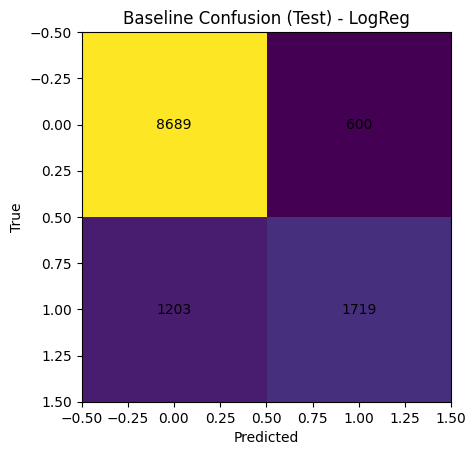

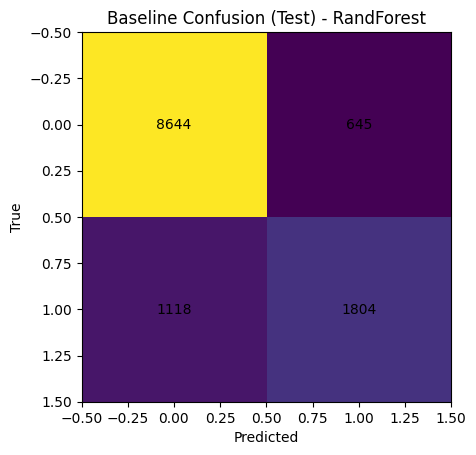

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


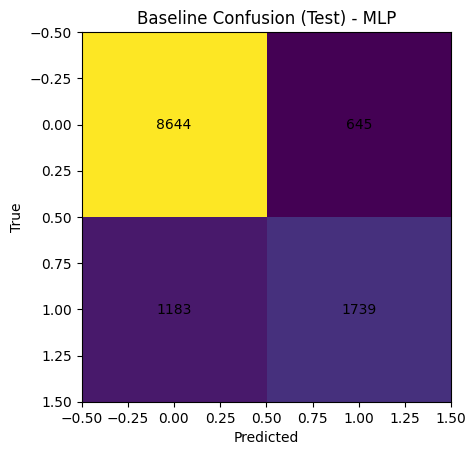

In [ ]:
# Confusion matrices (test) for baseline
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.show()

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    plot_confusion(y_test, y_pred, title=f"Baseline Confusion (Test) - {name}")


# Stress Test 1: Feature Noise Injection

We add Gaussian noise to **numeric columns only** (categoricals unchanged).  
Noise is scaled by each feature’s training-set standard deviation.

Levels here are fractions of each feature’s std-dev:
- 0.0 (clean)
- 0.1
- 0.25
- 0.5


In [ ]:
# --- Stress Test 1: Feature noise ---
def add_feature_noise(X: pd.DataFrame, num_cols: List[str], noise_level: float, rng: np.random.Generator) -> pd.DataFrame:
    Xn = X.copy()
    # Compute std from this dataframe (better: from training only; we’ll pass X_train stats separately if desired)
    # Here we compute stats externally and close over them for stability.
    return Xn

# Precompute training numeric std for scaling noise
train_num = X_train[num_cols].copy()
train_num = train_num.replace([np.inf, -np.inf], np.nan)
train_num_std = train_num.astype(float).std(axis=0, skipna=True).replace(0, 1.0)

def add_feature_noise_with_train_stats(X: pd.DataFrame, num_cols: List[str], noise_level: float, rng: np.random.Generator) -> pd.DataFrame:
    Xn = X.copy()
    if noise_level <= 0:
        return Xn
    for c in num_cols:
        if c not in Xn.columns:
            continue
        # Work in float; ignore non-finite values
        col = pd.to_numeric(Xn[c], errors="coerce")
        sigma = float(train_num_std.get(c, 1.0))
        noise = rng.normal(loc=0.0, scale=noise_level * sigma, size=len(Xn))
        Xn[c] = col + noise
    return Xn

noise_levels = [0.0, 0.1, 0.25, 0.5]
rng = np.random.default_rng(RANDOM_SEED)

noise_results = []  # rows of results

for nl in noise_levels:
    X_te_noisy = add_feature_noise_with_train_stats(X_test, num_cols, nl, rng)
    for model_name, base_pipe in pipelines.items():
        # Refit on clean training (keeps “deployment noise” interpretation)
        pipe = make_pipeline(models[model_name])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_te_noisy)
        y_score = safe_predict_proba(pipe, X_te_noisy)
        metrics = compute_metrics(y_test, y_pred, y_score)
        noise_results.append({"noise_level": nl, "model": model_name, **metrics})

noise_df = pd.DataFrame(noise_results)
noise_df


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


,noise_level,model,accuracy,precision,recall,f1,roc_auc
0,0.00,LogReg,0.852346,0.741268,0.588296,0.655982,0.904699
1,0.00,RandForest,0.855622,0.736627,0.617385,0.671756,0.904487
2,0.00,MLP,0.850299,0.729446,0.595140,0.655484,0.899266
3,0.10,LogReg,0.849644,0.732847,0.584873,0.650552,0.901700
4,0.10,RandForest,0.853738,0.740882,0.597878,0.661742,0.901467
5,0.10,MLP,0.848252,0.720594,0.597536,0.653321,0.897576
6,0.25,LogReg,0.842929,0.706584,0.587611,0.641629,0.892361
7,0.25,RandForest,0.847269,0.737528,0.561602,0.637653,0.896107
8,0.25,MLP,0.837442,0.682651,0.599247,0.638236,0.887293
9,0.50,LogReg,0.818688,0.634703,0.570842,0.601081,0.863625


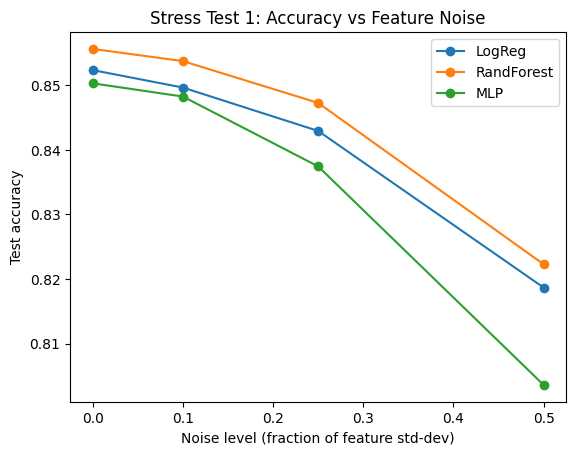

In [ ]:
# Plot: Accuracy vs noise_level
fig = plt.figure()
for model_name in noise_df["model"].unique():
    sub = noise_df[noise_df["model"] == model_name].sort_values("noise_level")
    plt.plot(sub["noise_level"], sub["accuracy"], marker="o", label=model_name)

plt.xlabel("Noise level (fraction of feature std-dev)")
plt.ylabel("Test accuracy")
plt.title("Stress Test 1: Accuracy vs Feature Noise")
plt.legend()
plt.show()


# Stress Test 2: Label Corruption

We corrupt the **training labels only** by flipping a fraction of labels at random.  
This simulates noisy annotation / heuristic labeling.

Corruption levels:
- 0.0
- 0.1
- 0.2
- 0.4


In [ ]:
# --- Stress Test 2: Label corruption ---
def corrupt_labels(y: np.ndarray, flip_frac: float, rng: np.random.Generator) -> np.ndarray:
    y2 = y.copy()
    if flip_frac <= 0:
        return y2
    n = len(y2)
    k = int(np.floor(flip_frac * n))
    idx = rng.choice(n, size=k, replace=False)
    y2[idx] = 1 - y2[idx]
    return y2

flip_fracs = [0.0, 0.1, 0.2, 0.4]
rng = np.random.default_rng(RANDOM_SEED)

label_noise_results = []

for ff in flip_fracs:
    y_tr_noisy = corrupt_labels(y_train.values if hasattr(y_train, "values") else np.array(y_train), ff, rng)
    for model_name, base_pipe in pipelines.items():
        pipe = make_pipeline(models[model_name])
        pipe.fit(X_train, y_tr_noisy)
        y_pred = pipe.predict(X_test)
        y_score = safe_predict_proba(pipe, X_test)
        metrics = compute_metrics(y_test, y_pred, y_score)
        label_noise_results.append({"flip_frac": ff, "model": model_name, **metrics})

label_noise_df = pd.DataFrame(label_noise_results)
label_noise_df


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


,flip_frac,model,accuracy,precision,recall,f1,roc_auc
0,0.0,LogReg,0.852346,0.741268,0.588296,0.655982,0.904699
1,0.0,RandForest,0.855622,0.736627,0.617385,0.671756,0.904487
2,0.0,MLP,0.850299,0.729446,0.595140,0.655484,0.899266
3,0.1,LogReg,0.850626,0.753932,0.557837,0.641227,0.901469
4,0.1,RandForest,0.843829,0.697702,0.612936,0.652578,0.873529
5,0.1,MLP,0.831463,0.647844,0.647844,0.647844,0.863917
6,0.2,LogReg,0.842519,0.749875,0.513005,0.609226,0.894189
7,0.2,RandForest,0.822455,0.633404,0.612594,0.622825,0.833239
8,0.2,MLP,0.793055,0.554483,0.687885,0.614022,0.828240
9,0.4,LogReg,0.828351,0.713326,0.472621,0.568547,0.865074


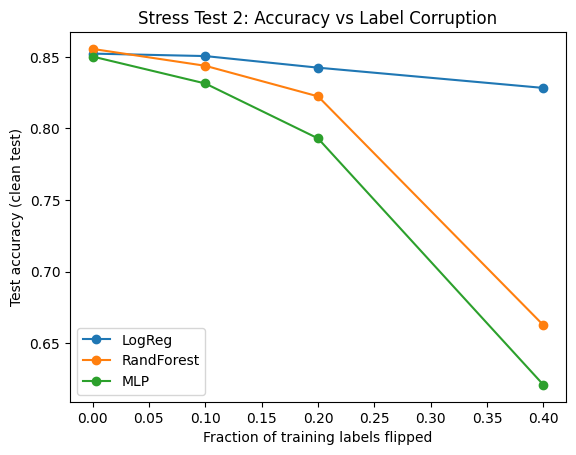

In [ ]:
# Plot: Accuracy vs label corruption
fig = plt.figure()
for model_name in label_noise_df["model"].unique():
    sub = label_noise_df[label_noise_df["model"] == model_name].sort_values("flip_frac")
    plt.plot(sub["flip_frac"], sub["accuracy"], marker="o", label=model_name)

plt.xlabel("Fraction of training labels flipped")
plt.ylabel("Test accuracy (clean test)")
plt.title("Stress Test 2: Accuracy vs Label Corruption")
plt.legend()
plt.show()


# Stress Test 3: Distribution Shift

We simulate a simple, interpretable distribution shift by splitting the population by **age**:
- Train on **Age > 35**
- Test on **Age ≤ 35**

If your dataset uses a different column name (sometimes `age`), update `SHIFT_COL`.


In [ ]:
# --- Stress Test 3: Distribution shift ---
SHIFT_COL = "age"  # Adult Income has 'age'
THRESH = 35

if SHIFT_COL not in X.columns:
    raise ValueError(f"SHIFT_COL='{SHIFT_COL}' not found in columns. Available: {list(X.columns)[:20]} ...")

# Train slice and test slice
train_mask = pd.to_numeric(X_train[SHIFT_COL], errors="coerce") > THRESH
test_mask = pd.to_numeric(X_test[SHIFT_COL], errors="coerce") <= THRESH

X_train_shift = X_train[train_mask].copy()
y_train_shift = y_train[train_mask].copy()

X_test_shift = X_test[test_mask].copy()
y_test_shift = y_test[test_mask].copy()

print("Train shift size:", X_train_shift.shape, "Test shift size:", X_test_shift.shape)

shift_results = {}
for model_name, base_pipe in pipelines.items():
    pipe = make_pipeline(models[model_name])
    shift_results[model_name] = eval_pipeline(pipe, X_train_shift, y_train_shift, X_test_shift, y_test_shift)

shift_df = pretty_metrics_table(shift_results)
shift_df


Train shift size: (19955, 14) Test shift size: (5670, 14)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,split,accuracy,precision,recall,f1,roc_auc
0,LogReg,test,0.891887,0.529340,0.655068,0.585531,0.915716
1,MLP,test,0.894356,0.547840,0.537065,0.542399,0.903974
2,RandForest,test,0.895591,0.549498,0.579425,0.564065,0.908305
3,LogReg,train,0.800100,0.741596,0.644664,0.689741,0.876341
4,MLP,train,0.861689,0.844891,0.733353,0.785181,0.941011
5,RandForest,train,0.999900,0.999709,1.000000,0.999855,1.000000


In [ ]:
# Plot: Train vs Test accuracy under shift
shift_acc = shift_df.pivot(index="model", columns="split", values="accuracy").reset_index()
shift_acc


split,model,test,train
0,LogReg,0.891887,0.800100
1,MLP,0.894356,0.861689
2,RandForest,0.895591,0.999900


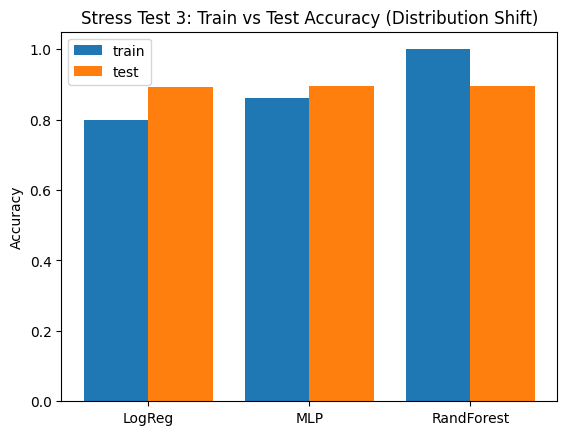

In [ ]:
fig = plt.figure()
x = np.arange(len(shift_acc))
plt.bar(x - 0.2, shift_acc["train"], width=0.4, label="train")
plt.bar(x + 0.2, shift_acc["test"], width=0.4, label="test")
plt.xticks(x, shift_acc["model"])
plt.ylabel("Accuracy")
plt.title("Stress Test 3: Train vs Test Accuracy (Distribution Shift)")
plt.legend()
plt.show()


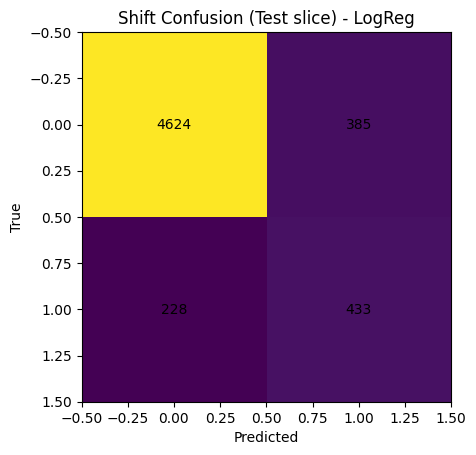

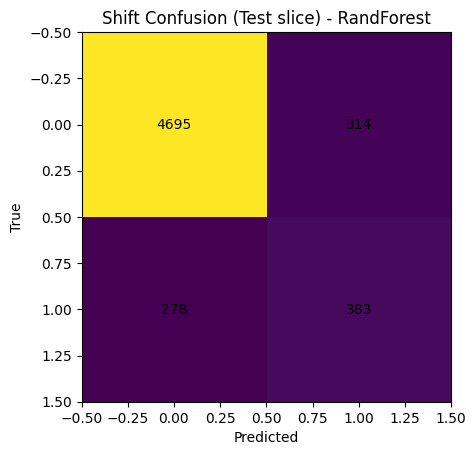

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


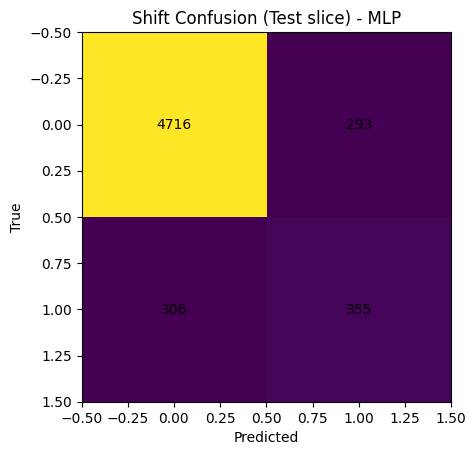

In [ ]:
# Confusion matrices under shift (test slice)
for model_name, base_pipe in pipelines.items():
    pipe = make_pipeline(models[model_name])
    pipe.fit(X_train_shift, y_train_shift)
    y_pred = pipe.predict(X_test_shift)
    plot_confusion(y_test_shift, y_pred, title=f"Shift Confusion (Test slice) - {model_name}")


# Stress Test 4: Feature Removal (Simulated Sensor Failure)

We train on clean training data, then **remove top-k important features** at test time.
- For Random Forest: use built-in `feature_importances_`  
- For Logistic Regression: use absolute coefficients  
- For MLP: we use a simple proxy (permutation drop) on a small subset for speed

To keep the notebook stable and fast, we’ll:
1) Train each model  
2) Extract a ranked list of important **original features** (before one-hot)  
3) Remove those columns from the raw test data

This gives an interpretable “what happens if key sensors/features disappear?” view.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

def build_preprocess_for_X(X: pd.DataFrame) -> ColumnTransformer:
    num_cols_local = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols_local = [c for c in X.columns if c not in num_cols_local]

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols_local),
            ("cat", categorical_transformer, cat_cols_local),
        ],
        remainder="drop",
    )

def make_pipeline_dynamic(model, X_ref: pd.DataFrame) -> Pipeline:
    return Pipeline(steps=[
        ("preprocess", build_preprocess_for_X(X_ref)),
        ("model", model),
    ])

# --- Stress Test 4: Feature removal ---
def fit_and_get_feature_ranking(model_name: str, X_tr: pd.DataFrame, y_tr: np.ndarray) -> List[str]:
    """Returns a ranking of ORIGINAL (pre-onehot) features to remove.
    For RF / LogReg, ranking uses the model’s learned importances (approx).
    For MLP, we fall back to Random Forest ranking (pragmatic, stable, demo-friendly).
    """
    pipe = make_pipeline(models[model_name])
    pipe.fit(X_tr, y_tr)

    # We need to look inside the pipeline
    pre = pipe.named_steps["preprocess"]
    mdl = pipe.named_steps["model"]

    # Create feature names AFTER preprocessing (includes one-hot)
    try:
        # sklearn >=1.0 supports get_feature_names_out
        feat_names = pre.get_feature_names_out()
    except Exception:
        feat_names = None

    if model_name == "RandForest":
        importances = mdl.feature_importances_
        idx_sorted = np.argsort(importances)[::-1]
    elif model_name == "LogReg":
        # For binary, coef_ shape is (1, n_features)
        coef = np.abs(mdl.coef_).ravel()
        idx_sorted = np.argsort(coef)[::-1]
    else:
        # MLP doesn’t have easy importances. Use RF ranking to keep project consistent and runnable.
        rf_pipe = make_pipeline(models["RandForest"])
        rf_pipe.fit(X_tr, y_tr)
        rf_pre = rf_pipe.named_steps["preprocess"]
        rf_mdl = rf_pipe.named_steps["model"]
        feat_names = rf_pre.get_feature_names_out()
        importances = rf_mdl.feature_importances_
        idx_sorted = np.argsort(importances)[::-1]

    # Map processed feature names back to original columns:
    # pre.get_feature_names_out prefixes with transformer names like 'num__age' or 'cat__workclass_...'
    # We strip to original column names by taking token after 'num__'/'cat__' then before onehot suffix.
    ranked_original = []
    if feat_names is not None:
        for i in idx_sorted:
            name = feat_names[i]
            # name looks like 'num__age' or 'cat__workclass_Private'
            if "__" in name:
                base = name.split("__", 1)[1]
            else:
                base = name
            # for onehot, base like 'workclass_Private' -> original 'workclass'
            if "_" in base and base.split("_", 1)[0] in X_tr.columns:
                # if column name itself contains underscores this can be imperfect; Adult columns are simple
                orig = base.split("_", 1)[0]
            else:
                # could be numeric column
                orig = base if base in X_tr.columns else base.split("_", 1)[0]
            if orig in X_tr.columns and orig not in ranked_original:
                ranked_original.append(orig)
    else:
        # Fallback: remove numeric first (least ideal)
        ranked_original = list(X_tr.columns)

    return ranked_original

rankings = {m: fit_and_get_feature_ranking(m, X_train, y_train) for m in pipelines.keys()}
{k: rankings[k][:10] for k in rankings}


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


{'LogReg': ['capital-gain',
  'marital-status',
  'native-country',
  'occupation',
  'sex',
  'relationship',
  'education-num',
  'race',
  'workclass',
  'education'],
 'RandForest': ['age',
  'fnlwgt',
  'marital-status',
  'hours-per-week',
  'capital-gain',
  'education-num',
  'relationship',
  'capital-loss',
  'occupation',
  'sex'],
 'MLP': ['age',
  'fnlwgt',
  'marital-status',
  'hours-per-week',
  'capital-gain',
  'education-num',
  'relationship',
  'capital-loss',
  'occupation',
  'sex']}

In [ ]:
# Ensure safe_predict_proba exists (run once)
def safe_predict_proba(pipe, X):
    try:
        proba = pipe.predict_proba(X)
        return proba[:, 1] if proba.shape[1] == 2 else None
    except Exception:
        return None

remove_ks = [0, 1, 2, 3, 5, 8, 12]
feature_removal_results = []

for model_name in ["LogReg", "RandForest", "MLP"]:  # explicit order
    ranking = rankings[model_name]

    for k in remove_ks:
        cols_to_remove = ranking[:k]
        X_tr_drop = X_train.drop(columns=cols_to_remove, errors="ignore")
        X_te_drop = X_test.drop(columns=cols_to_remove, errors="ignore")

        # sanity check (uncomment if needed)
        # print(model_name, "k=", k, "removed contains capital-gain?", "capital-gain" in cols_to_remove,
        #       "| in train cols?", "capital-gain" in X_tr_drop.columns)

        pipe = make_pipeline_dynamic(models[model_name], X_tr_drop)  # <-- THIS is the fix
        pipe.fit(X_tr_drop, y_train)

        y_pred = pipe.predict(X_te_drop)
        y_score = safe_predict_proba(pipe, X_te_drop)
        metrics = compute_metrics(y_test, y_pred, y_score)

        feature_removal_results.append({"model": model_name, "k_removed": k, **metrics})

feat_drop_df = pd.DataFrame(feature_removal_results)
feat_drop_df


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

,model,k_removed,accuracy,precision,recall,f1,roc_auc
0,LogReg,0,0.852346,0.741268,0.588296,0.655982,0.904699
1,LogReg,1,0.837687,0.710385,0.543121,0.615593,0.887354
2,LogReg,2,0.838424,0.712876,0.543806,0.616968,0.887308
3,LogReg,3,0.837687,0.712285,0.539699,0.614097,0.886606
4,LogReg,5,0.828515,0.694366,0.506160,0.585511,0.879998
5,LogReg,8,0.800262,0.657329,0.345311,0.452771,0.808200
6,LogReg,12,0.771354,0.684659,0.082478,0.147221,0.532189
7,RandForest,0,0.855622,0.736627,0.617385,0.671756,0.904487
8,RandForest,1,0.832528,0.667430,0.598220,0.630933,0.877657
9,RandForest,2,0.816968,0.594239,0.741273,0.659662,0.888744


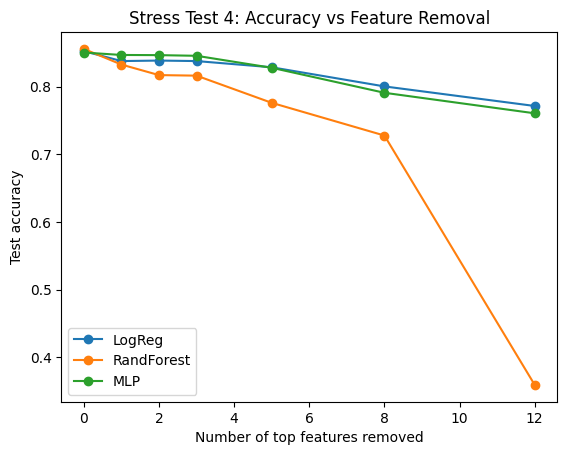

In [ ]:
# Plot: Accuracy vs k_removed
fig = plt.figure()
for model_name in feat_drop_df["model"].unique():
    sub = feat_drop_df[feat_drop_df["model"] == model_name].sort_values("k_removed")
    plt.plot(sub["k_removed"], sub["accuracy"], marker="o", label=model_name)

plt.xlabel("Number of top features removed")
plt.ylabel("Test accuracy")
plt.title("Stress Test 4: Accuracy vs Feature Removal")
plt.legend()
plt.show()


# Stress Test 5: Confidence Collapse

We compare the distribution of predicted probabilities under:
- Clean test data
- Noisy test data (from Stress Test 1)
- Shifted test slice (from Stress Test 3)

If a model is **overconfident**, you’ll see probabilities cluster near 0 or 1 even when accuracy drops.


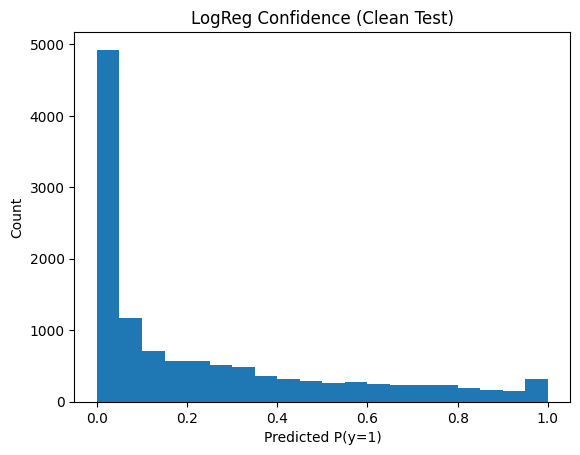

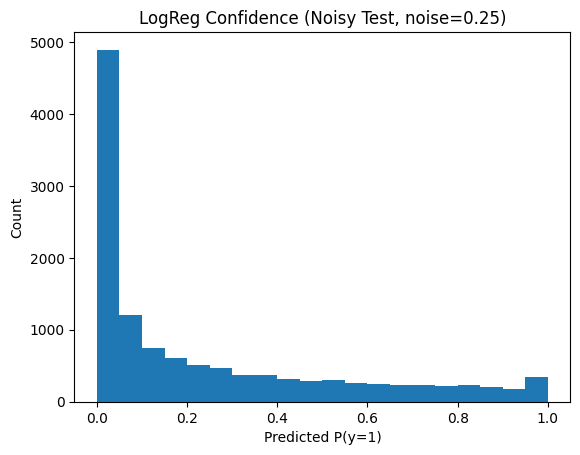

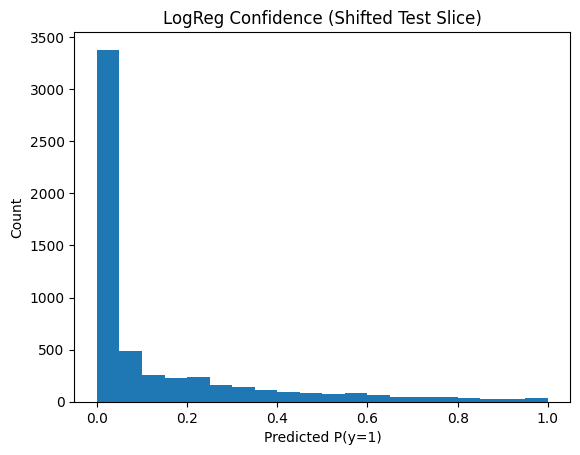

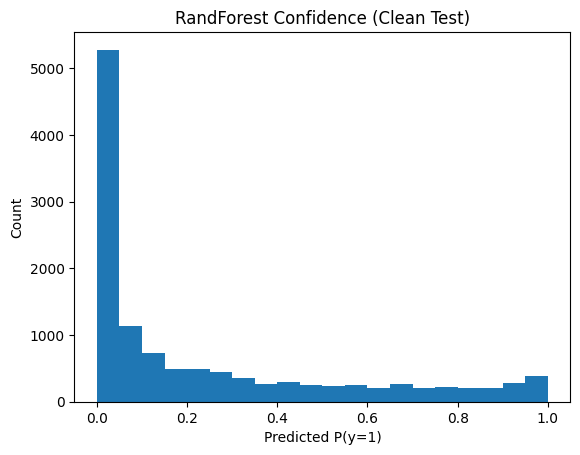

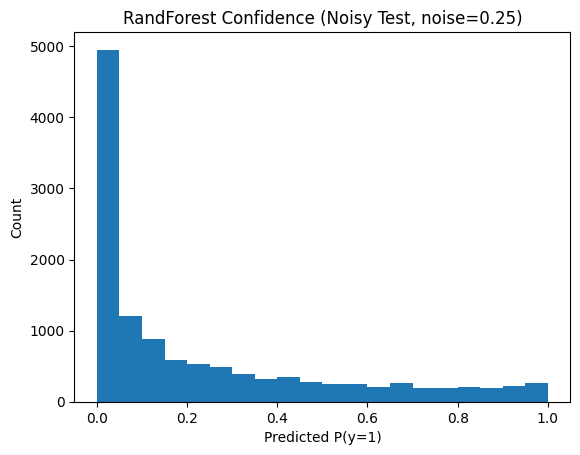

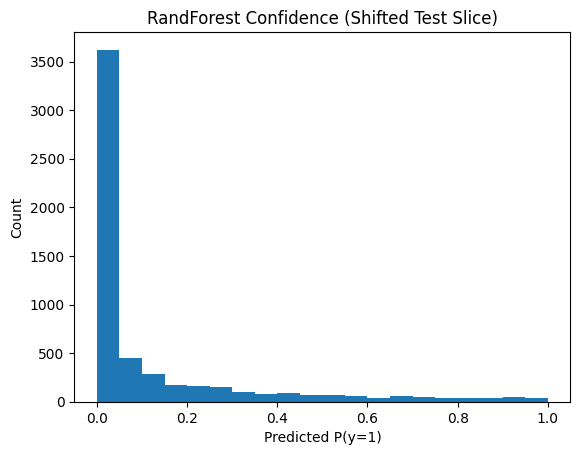

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


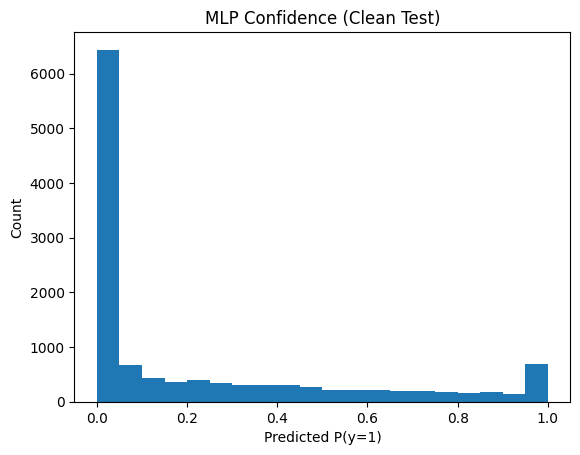

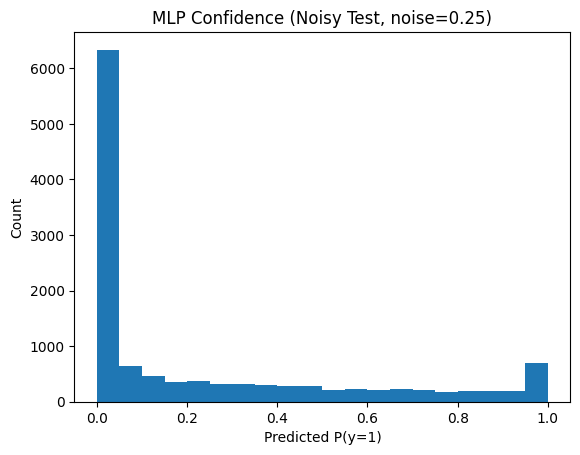

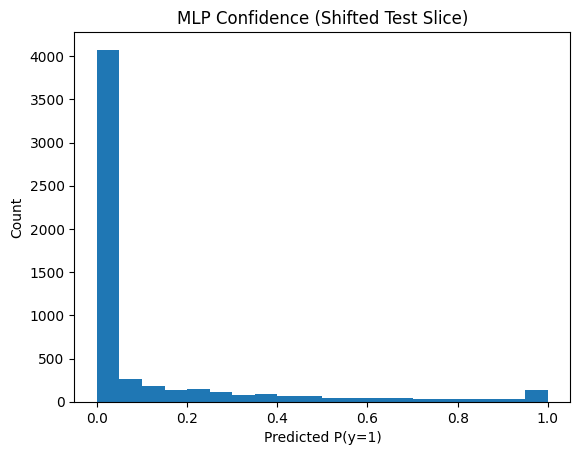

In [ ]:
# --- Stress Test 5: Confidence collapse ---
def plot_confidence_hist(scores: np.ndarray, title: str, bins: int = 20):
    fig = plt.figure()
    plt.hist(scores, bins=bins)
    plt.xlabel("Predicted P(y=1)")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# Choose a representative noise level
NOISE_FOR_CONF = 0.25
rng = np.random.default_rng(RANDOM_SEED)
X_test_noisy_conf = add_feature_noise_with_train_stats(X_test, num_cols, NOISE_FOR_CONF, rng)

for model_name in pipelines.keys():
    pipe = make_pipeline(models[model_name])
    pipe.fit(X_train, y_train)

    # Clean
    s_clean = safe_predict_proba(pipe, X_test)
    # Noisy
    s_noisy = safe_predict_proba(pipe, X_test_noisy_conf)
    # Shift slice (if non-empty)
    s_shift = safe_predict_proba(pipe, X_test_shift) if len(X_test_shift) > 0 else None

    if s_clean is not None:
        plot_confidence_hist(s_clean, f"{model_name} Confidence (Clean Test)")
    if s_noisy is not None:
        plot_confidence_hist(s_noisy, f"{model_name} Confidence (Noisy Test, noise={NOISE_FOR_CONF})")
    if s_shift is not None:
        plot_confidence_hist(s_shift, f"{model_name} Confidence (Shifted Test Slice)")


# 6) Summary Tables

We compile all stress test results into compact tables and (optionally) export as CSV.


In [ ]:
# --- Summary ---
def summarize_stress_tables():
    print("Baseline (clean):")
    display(baseline_df)

    print("\nFeature noise:")
    display(noise_df.pivot_table(index="noise_level", columns="model", values="accuracy"))

    print("\nLabel corruption:")
    display(label_noise_df.pivot_table(index="flip_frac", columns="model", values="accuracy"))

    print("\nDistribution shift (train/test):")
    display(shift_df.pivot_table(index="model", columns="split", values="accuracy"))

    print("\nFeature removal:")
    display(feat_drop_df.pivot_table(index="k_removed", columns="model", values="accuracy"))

summarize_stress_tables()


Baseline (clean):


,model,split,accuracy,precision,recall,f1,roc_auc
0,LogReg,test,0.852346,0.741268,0.588296,0.655982,0.904699
1,MLP,test,0.850299,0.729446,0.595140,0.655484,0.899266
2,RandForest,test,0.855622,0.736627,0.617385,0.671756,0.904487
3,LogReg,train,0.851437,0.733652,0.595208,0.657218,0.906760
4,MLP,train,0.898119,0.837197,0.712835,0.770027,0.958321
5,RandForest,train,0.999945,0.999772,1.000000,0.999886,1.000000



Feature noise:


model,LogReg,MLP,RandForest
noise_level,,,
0.00,0.852346,0.850299,0.855622
0.10,0.849644,0.848252,0.853738
0.25,0.842929,0.837442,0.847269
0.50,0.818688,0.803620,0.822291



Label corruption:


model,LogReg,MLP,RandForest
flip_frac,,,
0.0,0.852346,0.850299,0.855622
0.1,0.850626,0.831463,0.843829
0.2,0.842519,0.793055,0.822455
0.4,0.828351,0.620752,0.662436



Distribution shift (train/test):


split,test,train
model,,
LogReg,0.891887,0.800100
MLP,0.894356,0.861689
RandForest,0.895591,0.999900



Feature removal:


model,LogReg,MLP,RandForest
k_removed,,,
0,0.852346,0.850299,0.855622
1,0.837687,0.846696,0.832528
2,0.838424,0.846450,0.816968
3,0.837687,0.845467,0.816149
5,0.828515,0.827778,0.776022
8,0.800262,0.790844,0.727705
12,0.771354,0.760544,0.359430


In [ ]:
# Optional: export results (useful for slides / reporting)
baseline_df.to_csv("baseline_metrics.csv", index=False)
noise_df.to_csv("stress_feature_noise.csv", index=False)
label_noise_df.to_csv("stress_label_corruption.csv", index=False)
shift_df.to_csv("stress_distribution_shift.csv", index=False)
feat_drop_df.to_csv("stress_feature_removal.csv", index=False)

print("Saved CSVs to current working directory.")


## Notes for Reproducibility
- Keep `RANDOM_SEED` fixed for consistent results.
- If OpenML fetching fails, download Adult Income CSV and set `LOCAL_CSV_PATH`.
- For faster demos, reduce RandomForest trees and MLP iterations.
